In [1]:
import os, sys, glob

import argparse
parser = argparse.ArgumentParser()
# Dataset
parser.add_argument('--set', type=str, default='valid')
# Model/Config
parser.add_argument('--step', type=str, default='050000')
parser.add_argument('--ckpt_selector', type=str, default='ema')
parser.add_argument('--cfg_name', type=str, default=None)
parser.add_argument('--log_dir', type=str, default=None)
# Interpolation
parser.add_argument('--interpolate', nargs='+', default=None)
parser.add_argument('--interpolate_step', type=int, default=15)
parser.add_argument('--interpolate_noise', action='store_true', default=False)
parser.add_argument('--lerp', action='store_true', default=False)
parser.add_argument('--slerp', action='store_true', default=False)
parser.add_argument('--uncond_sampling', action='store_true', default=False)
parser.add_argument('--uncond_sampling_iters', type=int, default=1)
parser.add_argument('--reverse_sampling', action='store_true', default=False)
parser.add_argument('--separate_reverse_sampling', action='store_true', default=False)
# Samples selection
parser.add_argument('--n_subject', type=int, default=-1)
parser.add_argument('--sample_pair_json', type=str, default=None)
parser.add_argument('--sample_pair_mode', type=str, default=None)
parser.add_argument('--src_dst', nargs='+', default=[])
# Pertubation the image condition
parser.add_argument('--perturb_img_cond', action='store_true', default=False)
parser.add_argument('--perturb_mode', type=str, default='zero')
parser.add_argument('--perturb_where', nargs='+', default=[])

# Rendering
parser.add_argument('--render_mode', type=str, default="shape")
parser.add_argument('--rotate_normals', action='store_true', default=False)
# Diffusion
parser.add_argument('--diffusion_steps', type=int, default=1000)
parser.add_argument('--denoised_clamp', type=float, default=None)
# Misc.
parser.add_argument('--seed', type=int, default=23)
parser.add_argument('--gpu_id', type=str, default="0")
parser.add_argument('--save_intermediate', action='store_true', default=False)
parser.add_argument('--postfix', type=str, default='')
parser.add_argument('--ovr_img', type=str, default=None)
parser.add_argument('--ovr_mod', action='store_true', default=False)
parser.add_argument('--norm_img', action='store_true', default=False)
parser.add_argument('--use_global_norm', action='store_true', default=False)
parser.add_argument('--norm_space', type=str, default='rgb')

args = parser.parse_args(args=[])

import os, sys, glob
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import PIL, cv2
import json
import copy
import time
import torchvision
import pytorch_lightning as pl
sys.path.insert(0, '../../../')
from guided_diffusion.script_util import (
    seed_all,
)

from guided_diffusion.tensor_util import (
    make_deepcopyable,
)

import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs, figsize=(8, 6)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

# Sample utils
sys.path.insert(0, '../../')
from sample_utils import (
    ckpt_utils, 
    params_utils, 
    vis_utils, 
    file_utils, 
    inference_utils, 
    mani_utils,
)
device = 'cuda' if th.cuda.is_available() and th._C._cuda_getDeviceCount() > 0 else 'cpu'

In [2]:
seed_all(47)

################ SETTINGS ################
args.cfg_name = "Masked_Face_woclip_no_nonspatial.yaml"
args.log_dir = "Masked_Face_woclip_no_nonspatial"
args.step = '050000'
args.ckpt_selector = 'ema'
args.set = 'valid'
args.sample_pair_json = './sample_json/ipynb_samples.json'
args.sample_pair_mode = 'pair'

# Load Ckpt
if args.cfg_name is None:
    args.cfg_name = args.log_dir + '.yaml'
ckpt_loader = ckpt_utils.CkptLoader(log_dir=args.log_dir, cfg_name=args.cfg_name)
cfg = ckpt_loader.cfg

print(f"[#] Sampling with diffusion_steps = {args.diffusion_steps}")
cfg.diffusion.diffusion_steps = args.diffusion_steps
model_dict, diffusion = ckpt_loader.load_model(ckpt_selector=args.ckpt_selector, step=args.step)
model_dict = inference_utils.eval_mode(model_dict)

# Load dataset
if args.set == 'itw':
    img_dataset_path = "../../itw_images/aligned/"
    deca_dataset_path = None
elif args.set == 'train' or args.set == 'valid':
    img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
else: raise NotImplementedError

loader, dataset, avg_dict = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector,
    rmv_params=cfg.param_model.rmv_params,
    set_=args.set,
    cfg=cfg,
    mode='sampling'
)

# DECA Rendering
if np.any(['deca_masked' in n for n in list(filter(None, dataset.condition_image))]):
    mask = params_utils.load_flame_mask()
else: 
    mask=None
deca_obj = params_utils.init_deca(mask=mask)

[#] Model Path : 
#0 : /data/mint/model_logs_mount/v6/Masked_Face_woclip_no_nonspatial/
[#] Config Path :  ['/home/mint/guided-diffusion/config/CVPRs/Brightness_Exp/Masked_Face_woclip_no_nonspatial.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/CVPRs/Brightness_Exp/Masked_Face_woclip_no_nonspatial.yaml')

[#] Sampling with diffusion_steps = 1000
[#] Available ckpt :  ['_000000.pt', '_000000.pt', '_010000.pt', '_010000.pt', '_020000.pt', '_020000.pt', '_030000.pt', '_030000.pt', '_040000.pt', '_040000.pt', '_050000.pt', '_050000.pt', '_060000.pt', '_060000.pt', '_070000.pt', '_070000.pt', '_080000.pt', '_080000.pt', '_090000.pt', '_090000.pt', '_100000.pt', '_100000.pt', '_110000.pt', '_110000.pt', '_120000.pt', '_120000.pt', '_130000.pt', '_130000.pt', '_140000.pt', '_140000.pt', '_150000.pt', '_150000.pt', '_160000.pt', '_160000.pt', '_170000.pt', '_170000.pt', '_180000.pt', '_180000.pt', '_190000.pt', '_190000.pt', '_200000.pt', '_200000.pt', '_210000.pt', '

Loading deca params...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  []
Remove keys :  []
Input Image :  ['raw']
Image condition :  ['deca_masked_face_images_woclip']
DPM Image condition :  [None]
creating the FLAME Decoder
[#] DECA : SRenderY applied mask


In [3]:
data_size = dataset.__len__()
img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{args.set}")


denoised_fn = None
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, 
                                            diffusion=diffusion, 
                                            reverse_fn=diffusion.ddim_reverse_sample_loop, 
                                            forward_fn=diffusion.ddim_sample_loop,
                                            denoised_fn=denoised_fn,
                                            cfg=cfg,
                                            args=args)

def rgb_to_gray(img):
    out = (img[:, 0:1] * 0.2989) + (img[:, 1:2] * 0.5870) + (img[:, 2:3] * 0.1140)
    return out

In [259]:
def reverse_proc_override(self, x, model_kwargs, progress=True, store_intermediate=True):
    # Mimic the ddim_sample_loop or p_sample_loop
    print("reverse_proc_override")
    model_kwargs['const_noise'] = self.const_noise
    sample, intermediate = self.reverse_fn(
        model=self.model_dict[self.cfg.img_model.name],
        x=x.cuda(),
        clip_denoised=True,
        denoised_fn = self.denoised_fn,
        model_kwargs=model_kwargs,
        progress=progress,
        store_intermidiate=store_intermediate,
        cond_xt_fn=cond_xt_fn if model_kwargs['use_cond_xt_fn'] else None
    )

    return {"final_output":sample, "intermediate":intermediate}
    
    
def ddim_reverse_sample_loop_override(
    self,
    model,
    x,
    model_kwargs,
    clip_denoised,
    denoised_fn=None,
    cond_xt_fn=None,
    progress=True,
    device=None,
    store_intermidiate=False):
    """
    Generate samples from the model using DDIM.

    Same usage as p_sample_loop().
    """
    print("ddim_reverse_sample_loop_override 2")
    final = None
    intermediate = [th.std_mean(x[0])] # **********
    for sample in self.ddim_reverse_sample_loop_progressive(
        model=model,
        x=x,
        clip_denoised=clip_denoised,
        denoised_fn=denoised_fn,
        model_kwargs=model_kwargs,
        cond_xt_fn=cond_xt_fn,
        progress=progress,
        device=device,
        eta=0.0,
    ):
        final = sample

        intermediate.append(th.std_mean(sample['sample'][0]))

    return final, intermediate


def ddim_sample_loop_progressive_override(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=True,
        denoised_fn=None,
        cond_xt_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
        eta=0.0,
        sdedit=None
    ):
        global in_stdmean
        global out_stdmean, ver_stdmean
        global diff_stdmean
        global flag
        
        out_stdmean = []
        ver_stdmean = []
        #print(in_stdmean[0])
        print("ddim_sample_loop_progressive_override 2")
        """
        Use DDIM to sample from the model and yield intermediate samples from
        each timestep of DDIM.

        Same usage as p_sample_loop_progressive().
        """
        if device is None:
            device = next(model.parameters()).device
        assert isinstance(shape, (tuple, list))
        if noise is not None:
            x = noise
        else:
            x = th.randn(*shape, device=device)
        indices = list(range(self.num_timesteps))[::-1]

        if progress:
            # Lazy import so that we don't depend on tqdm.
            from tqdm.auto import tqdm

            indices = tqdm(indices)

        for i in indices:
            t = th.tensor([i] * shape[0], device=device)
            # Deep copy to prevent sth that used .pop()
            model_kwargs_copy = make_deepcopyable(model_kwargs, keys=list(model_kwargs.keys()))
            if cond_xt_fn is not None:
                model_kwargs_copy = cond_xt_fn(cond=model_kwargs_copy, 
                                               t=t, 
                                               cfg=model_kwargs_copy['cfg'],
                                               use_render_itp=model_kwargs_copy['use_render_itp'],
                                               diffusion=self,
                                               noise=model_kwargs_copy['const_noise']
                                            )
            with th.no_grad():
                out = self.ddim_sample(
                    model,
                    x,
                    t,
                    clip_denoised=clip_denoised,
                    denoised_fn=denoised_fn,
                    model_kwargs=model_kwargs_copy,
                    eta=eta,
                )
                
                sd, mean = th.std_mean(out["sample"][0])
                out_stdmean.append((sd, mean))
                
                sd_dest, mean_dest = in_stdmean[i]
                if flag == 1:
                    out["sample"] = (out["sample"] - mean) / sd * sd_dest + mean_dest 
                elif flag == 2:
                    out["sample"] = (out["sample"] - mean) + mean_dest 
                elif flag == 3:
                    out["sample"] = (out["sample"] / sd ) * sd_dest
                elif flag == -1:
                    out["sample"] = out["sample"] + diff_stdmean[i]
               
                ver_stdmean.append(th.std_mean(out["sample"][0]))
                x = out["sample"]
                out['t'] = t
                yield out

In [260]:
import types
pl_sampling.reverse_proc = types.MethodType(reverse_proc_override, pl_sampling)
pl_sampling.reverse_fn = types.MethodType(ddim_reverse_sample_loop_override, pl_sampling.diffusion)
pl_sampling.diffusion.ddim_sample_loop_progressive = types.MethodType(
    ddim_sample_loop_progressive_override,
    pl_sampling.diffusion)


In [261]:
def inversion(img, cond):
    '''
    :param dat: images in B x C x H x W
    '''
    cond['use_cond_xt_fn'] = False
    cond['dpm_cond_img'] = None 
    
    # Reverse   
    reverse_ddim_sample = pl_sampling.reverse_proc(x=img, model_kwargs=cond, store_intermediate=True)

    noise_map = reverse_ddim_sample['final_output']['sample']
    # Forward   
    sample_ddim = pl_sampling.forward_proc(noise=noise_map, model_kwargs=cond, store_intermediate=False)
    
    out = sample_ddim['final_output']['sample']
    return (out + 1) * 0.5    


# Manipulate the condition

In [262]:
def make_condition(cond, src_idx, dst_idx, n_step=2, itp_func=None):
    condition_img = list(filter(None, dataset.condition_image))
    misc = {'condition_img':condition_img,
            'src_idx':src_idx,
            'dst_idx':dst_idx,
            'n_step':n_step,
            'avg_dict':avg_dict,
            'dataset':dataset,
            'args':args,
            'itp_func':itp_func,
            'img_size':cfg.img_model.image_size,
            'deca_obj':deca_obj
            }  
    if itp_func is not None:
        cond['use_render_itp'] = False 
    else:
        cond['use_render_itp'] = True
        
    cond, clip_ren = inference_utils.build_condition_image(cond=cond, misc=misc)
    cond = inference_utils.prepare_cond_sampling(cond=cond, cfg=cfg, use_render_itp=True)
    

    if 'render_face' in args.interpolate:
        interp_set = args.interpolate.copy()
        interp_set.remove('render_face')
    interp_cond = mani_utils.iter_interp_cond(cond, interp_set=interp_set, src_idx=src_idx, dst_idx=dst_idx, n_step=n_step, interp_fn=itp_func)
    cond.update(interp_cond)
        
    repeated_cond = mani_utils.repeat_cond_params(cond, base_idx=src_idx, n=n_step, key=mani_utils.without(cfg.param_model.params_selector, args.interpolate + ['light', 'img_latent']))
    cond.update(repeated_cond)

    # Finalize the cond_params
    cond = mani_utils.create_cond_params(cond=cond, key=mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params))
    if cfg.img_cond_model.override_cond != '':
        to_tensor_key = ['cond_params'] + cfg.param_model.params_selector + [cfg.img_cond_model.override_cond]
    else:    
        to_tensor_key = ['cond_params'] + cfg.param_model.params_selector
    cond = inference_utils.to_tensor(cond, key=to_tensor_key, device=ckpt_loader.device)
    
    return cond
    

# Inversion 

[#] Interpolate with <function slerp at 0x7fc377b3fa60>
Rendering time :  1.1577529907226562
[#] Repeating cond :  []
[#] Condition build from parameters in  []
[#] With normalize


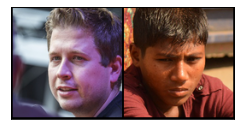

In [296]:
from pytorch_lightning import seed_everything


all_img_idx, all_img_name, args.n_subject = mani_utils.get_samples_list(args.sample_pair_json, 
                                                                        args.sample_pair_mode, 
                                                                        args.src_dst, img_path, 
                                                                        args.n_subject)

idx = 5 # Sample index related to json order
img_idx = all_img_idx[idx]
img_name = all_img_name[idx]

dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=2,
                                    shuffle=False, num_workers=2)
                            
# Load image & condition                            
dat, model_kwargs = list(iter(subset_loader))[0]
show(torchvision.utils.make_grid((dat + 1) * 0.5), figsize=(4, 8))
# Rendering
args.interpolate = ['render_face']
cond = copy.deepcopy(model_kwargs)
cond = make_condition(cond=cond, 
                      src_idx=0, dst_idx=1, 
                      n_step=2, itp_func=mani_utils.slerp)
cond['use_cond_xt_fn'] = False
cond['dpm_cond_img'] = None 

# Forward to Encoder
if cfg.img_cond_model.apply:
    cond_rev = pl_sampling.forward_cond_network(model_kwargs={'cond_img':cond['cond_img'][0:1]})
    
# print(model_kwargs['image_name'][0].split('.')[0])
# Reverse & Forward
print("[#] With normalize")
#out = inversion(dat, cond_rev)

    
    
#show(torchvision.utils.make_grid(out_norm), figsize=(15, 15))
#



In [297]:
cond_rev['use_cond_xt_fn'] = False
cond_rev['dpm_cond_img'] = None 
    
#dat2 = th.clip(dat + th.randn_like(dat) * 0.1, -1, 1)
    # Reverse   
#reverse_ddim_sample = pl_sampling.reverse_proc(dat2, cond_rev, store_intermediate=True)
reverse_ddim_sample = pl_sampling.reverse_proc(dat, cond_rev, store_intermediate=True)

reverse_proc_override
ddim_reverse_sample_loop_override 2


  0%|          | 0/1000 [00:00<?, ?it/s]

In [298]:
in_stdmean = reverse_ddim_sample['intermediate']

samples = [dat]
flag = 2
sample_ddim = pl_sampling.forward_proc(
    noise=reverse_ddim_sample['final_output']['sample'],
    model_kwargs=cond_rev,
    store_intermediate=False)

samples.append(sample_ddim["final_output"]["sample"])


ddim_sample_loop_progressive_override 2


  0%|          | 0/1000 [00:00<?, ?it/s]

In [299]:
saved_out_stdmean = out_stdmean
saved_in_stdmean = in_stdmean
print(saved_in_stdmean[10])
print(ver_stdmean[-11])

(tensor(0.48032, device='cuda:0', dtype=torch.float64), tensor(-0.13463, device='cuda:0', dtype=torch.float64))
(tensor(0.43721, device='cuda:0', dtype=torch.float64), tensor(-0.13463, device='cuda:0', dtype=torch.float64))


In [300]:
cond_relight = pl_sampling.forward_cond_network(model_kwargs=cond)

In [301]:
diff_stdmean = [saved_in_stdmean[x][1] - saved_out_stdmean[999-x][1] for x in range(1000)]
print(diff_stdmean[997])
print(saved_in_stdmean[997][1] - saved_out_stdmean[2][1])

tensor(3.97100e-07, device='cuda:0', dtype=torch.float64)
tensor(3.97100e-07, device='cuda:0', dtype=torch.float64)


In [302]:
flag = -1
noise_map = reverse_ddim_sample['final_output']['sample'][0:1]
relight_out = pl_sampling.forward_proc(
    noise=th.repeat_interleave(noise_map, repeats=2, dim=0),
    model_kwargs=cond_relight,
    store_intermediate=False)


ddim_sample_loop_progressive_override 2


  0%|          | 0/1000 [00:00<?, ?it/s]

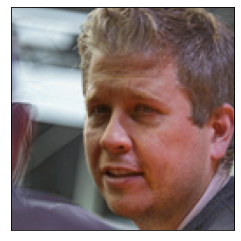

In [303]:
relight_output = relight_out["final_output"]["sample"][1]
show(torchvision.utils.make_grid((relight_output + 1) * 0.5), figsize=(4, 8))

In [182]:
in_stdmean = reverse_ddim_sample['intermediate']

samples = [dat]
for i in range(5):
    flag = i
    sample_ddim = pl_sampling.forward_proc(
        noise=reverse_ddim_sample['final_output']['sample'],
        model_kwargs=cond_rev,
        store_intermediate=False)
    
    samples.append(sample_ddim["final_output"]["sample"])

((tensor(0.54039, device='cuda:0', dtype=torch.float64), tensor(-0.60305, device='cuda:0', dtype=torch.float64)), tensor(-0.83529, device='cuda:0', dtype=torch.float64))
ddim_sample_loop_progressive_override 2


  0%|          | 0/1000 [00:00<?, ?it/s]

((tensor(0.54039, device='cuda:0', dtype=torch.float64), tensor(-0.60305, device='cuda:0', dtype=torch.float64)), tensor(-0.83529, device='cuda:0', dtype=torch.float64))
ddim_sample_loop_progressive_override 2


  0%|          | 0/1000 [00:00<?, ?it/s]

((tensor(0.54039, device='cuda:0', dtype=torch.float64), tensor(-0.60305, device='cuda:0', dtype=torch.float64)), tensor(-0.83529, device='cuda:0', dtype=torch.float64))
ddim_sample_loop_progressive_override 2


  0%|          | 0/1000 [00:00<?, ?it/s]

((tensor(0.54039, device='cuda:0', dtype=torch.float64), tensor(-0.60305, device='cuda:0', dtype=torch.float64)), tensor(-0.83529, device='cuda:0', dtype=torch.float64))
ddim_sample_loop_progressive_override 2


  0%|          | 0/1000 [00:00<?, ?it/s]

((tensor(0.54039, device='cuda:0', dtype=torch.float64), tensor(-0.60305, device='cuda:0', dtype=torch.float64)), tensor(-0.83529, device='cuda:0', dtype=torch.float64))
ddim_sample_loop_progressive_override 2


  0%|          | 0/1000 [00:00<?, ?it/s]

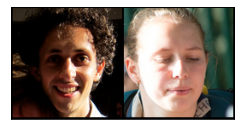

In [32]:
show(torchvision.utils.make_grid((dat + 1) * 0.5), figsize=(4, 8))

(tensor(0.65902, dtype=torch.float64), tensor(-0.27192, dtype=torch.float64))
(tensor(0.52328, device='cuda:0', dtype=torch.float64), tensor(-0.48559, device='cuda:0', dtype=torch.float64))


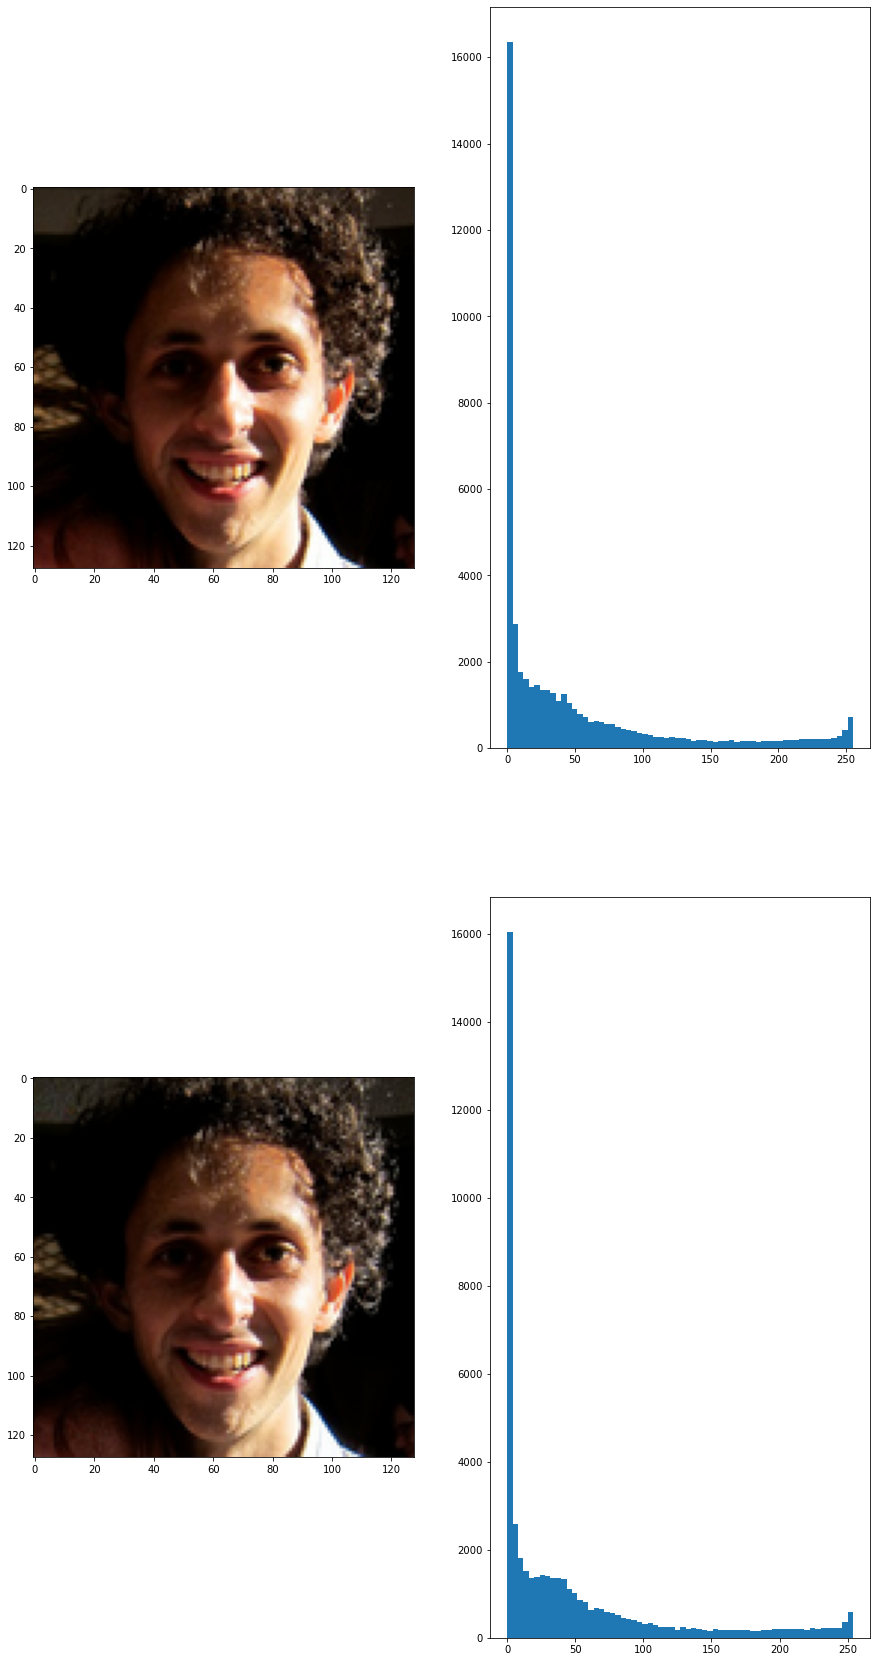

In [203]:
fig, axs = plt.subplots(len(samples), 2, figsize=(15, 30))
#fig, axs = plt.subplots(2, 2, figsize=(15, 15))
for i, img in enumerate(samples):
#    img = F.to_pil_image(th.clip((img[0] + 1) *  0.5, 10/255.0, 254/255))
    print(th.std_mean(img))
    img = F.to_pil_image(th.clip((img[0] + 1) *  0.5, 0, 1))
    img = np.asarray(img)
    axs[i, 0].imshow(img)

    #axs[i, 1].hist(img[img > 1/255.0].ravel(), bins = 64)
    axs[i, 1].hist(img.ravel(), bins = 64)

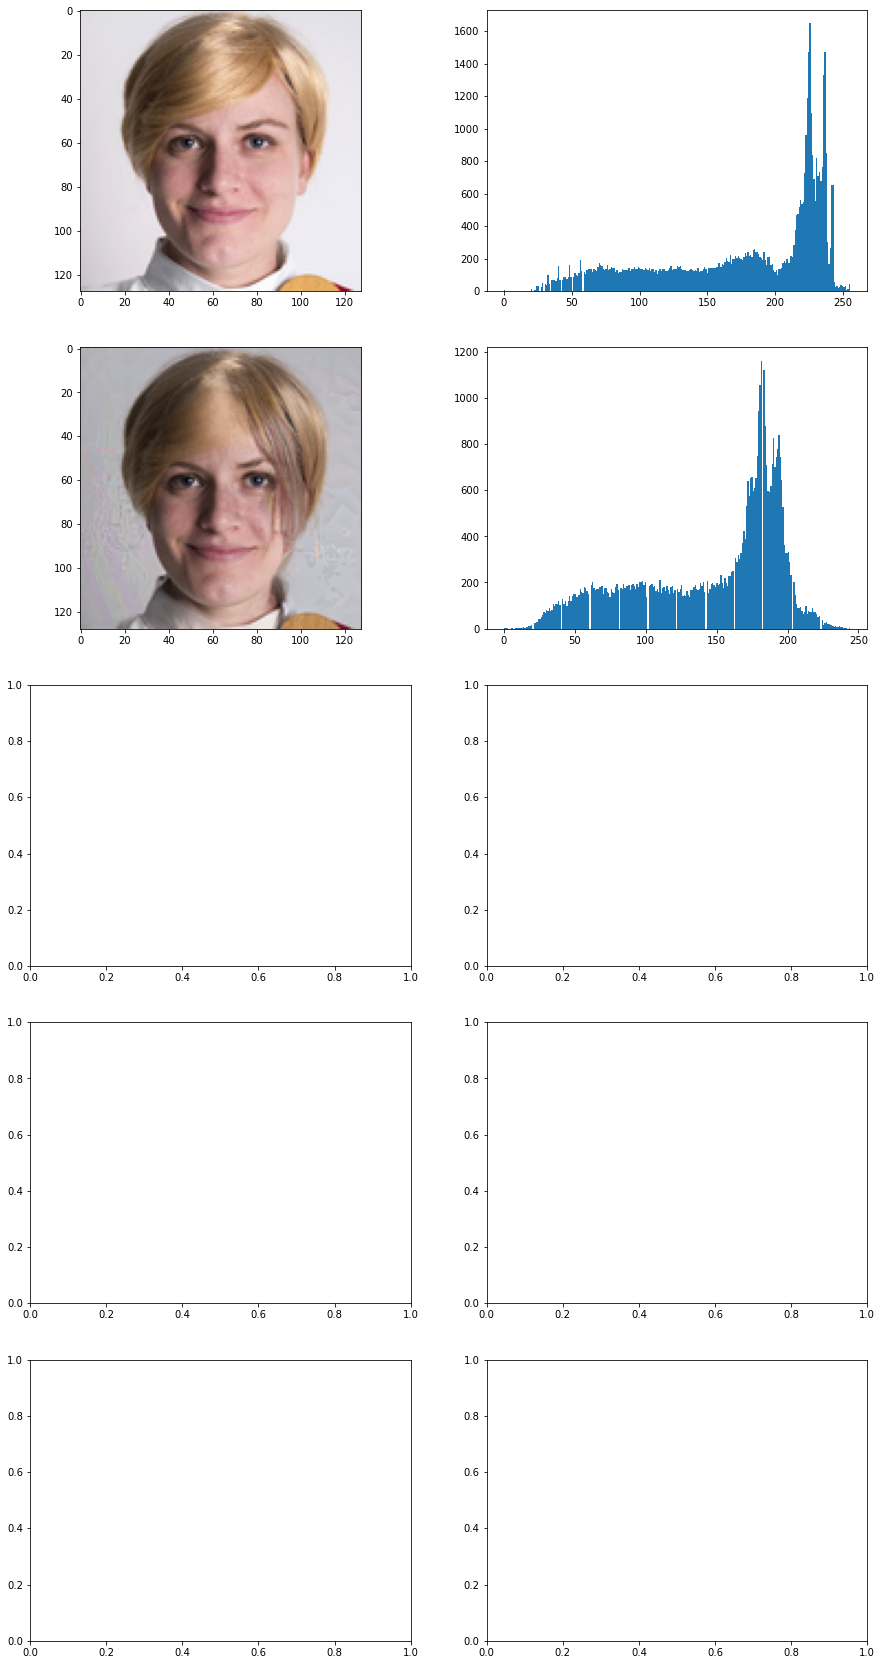

In [22]:
#samples[0]
#img = F.to_pil_image(th.clip((samples[0][0] + 1) * 0.5, 0, 1))
#image = np.asarray(img)

fig, axs = plt.subplots(5, 2, figsize=(15, 30))
for i, img in enumerate(samples):
    img = F.to_pil_image(th.clip((img[0] + 1) * 0.5, 0, 1))
    axs[i, 0].imshow(np.asarray(img))
    axs[i, 1].hist(np.asarray(img).ravel(), bins = 256)
#    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

(tensor(0.57262, device='cuda:0', dtype=torch.float64), tensor(-0.27192, device='cuda:0', dtype=torch.float64))
tensor(-0.99998, device='cuda:0', dtype=torch.float64)
tensor(1.00002, device='cuda:0', dtype=torch.float64)


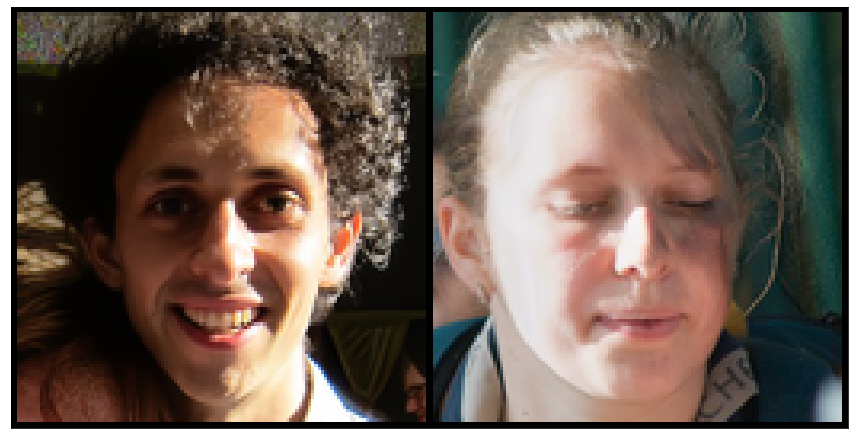

In [84]:
out = sample_ddim["final_output"]["sample"]
print(th.std_mean(out))
print(th.min(out))
print(th.max(out))
show(torchvision.utils.make_grid(th.clip((out + 1) * 0.5, 0, 1)), figsize=(15, 15))

(tensor(0.65902, dtype=torch.float64), tensor(-0.27192, dtype=torch.float64))
tensor(-1., dtype=torch.float64)
tensor(1., dtype=torch.float64)


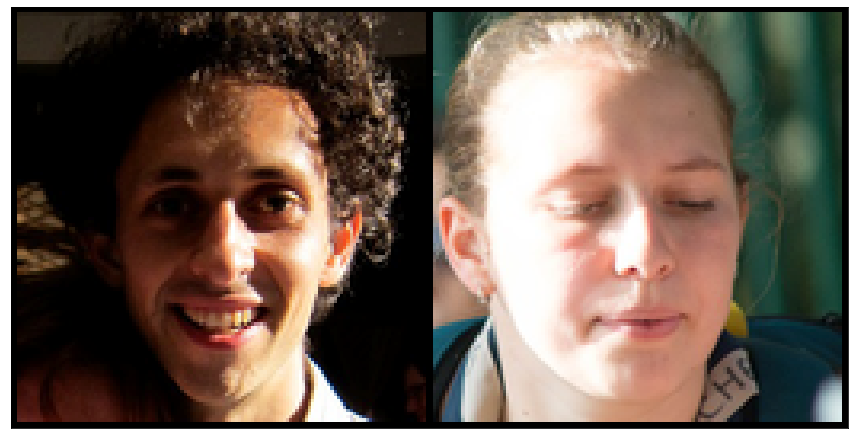

In [70]:
print(th.std_mean(dat))
print(th.min(dat))
print(th.max(dat))
#show(torchvision.utils.make_grid(th.clip((dat + th.randn_like(dat) * 0.1 + 1) * 0.5, 0, 1)), figsize=(15, 15))
show(torchvision.utils.make_grid(th.clip((dat + 1) * 0.5, 0, 1)), figsize=(15, 15))

# Relighting

In [188]:
def relight(dat, model_kwargs, norm_img, n_step=3, sidx=0, didx=1):
    show(torchvision.utils.make_grid((dat + 1) * 0.5), figsize=(4, 8))
    # Rendering
    args.interpolate = ['render_face']
    cond = copy.deepcopy(model_kwargs)
    cond['use_cond_xt_fn'] = False
    cond['dpm_cond_img'] = None 
    cond = make_condition(cond=cond, 
                        src_idx=sidx, dst_idx=didx, 
                        n_step=n_step, itp_func=mani_utils.slerp)
    show(torchvision.utils.make_grid(th.clip(cond['cond_img'], 0, 1)), figsize=(4, 8))

    # Reverse 
    if cfg.img_cond_model.apply:
        cond_rev = pl_sampling.forward_cond_network(model_kwargs={'cond_img':cond['cond_img'][0:1, ...]})
        print(cond_rev['spatial_latent'][0].shape)
        
    cond_rev['use_cond_xt_fn'] = False
    cond_rev['dpm_cond_img'] = None 
    noise_map, nf = reverse(dat=dat[0:1, ...], norm_img=norm_img, cond=cond_rev)

    # Relight!
    if cfg.img_cond_model.apply:
        cond = pl_sampling.forward_cond_network(model_kwargs=cond)
        print(cond['spatial_latent'][0].shape)
    out = forward(noise_map=th.repeat_interleave(noise_map, repeats=n_step, dim=0), cond=cond, norm_img=norm_img, nf=nf)
    show(torchvision.utils.make_grid(out), figsize=(4, 8))
    return out



Replacing :  None
[#] Interpolate with <function slerp at 0x7fc377b3fa60>
Rendering time :  0.9046838283538818
[#] Repeating cond :  []
[#] Condition build from parameters in  []
torch.Size([1, 128, 128, 128])


NameError: name 'reverse' is not defined

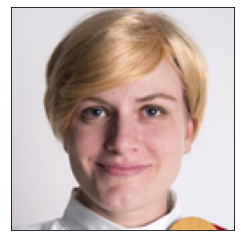

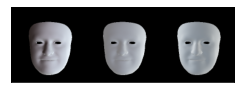

In [187]:
all_img_idx, all_img_name, args.n_subject = mani_utils.get_samples_list(args.sample_pair_json, 
                                                                        args.sample_pair_mode, 
                                                                        args.src_dst, img_path, 
                                                                        args.n_subject)

idx = 2 # Sample index related to json order
img_idx = all_img_idx[idx]
img_name = all_img_name[idx]
n_step = 3

dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=2,
                                    shuffle=False, num_workers=24)
                            
# Load image & condition                        
# for i in ['60182.jpg', '60008.jpg', '68782.jpg', -1.0, -0.5, 0.0, 0.5, 1.0]:
dat, model_kwargs = list(iter(subset_loader))[0]
d_tmp = []

# balancedNdist_bg = [{'balance_Ndist':{'sd':58.050383371049826/127.5, 'clip':True}}] 
# balancedNdist_bg = [{'balance_Ndist':{'sd':0.1, 'clip':True}}, {'balance_Ndist':{'sd':0.5, 'clip':True}}, {'balance_Ndist':{'sd':58.050383371049826/127.5, 'clip':True}}] 
rpl_bg = [None, {'balance_Ndist':{'sd':0.1, 'clip':True}}, {'balance_Ndist':{'sd':0.5, 'clip':True}}, {'balance_Ndist':{'sd':58.050383371049826/127.5, 'clip':True}}] 
for i in rpl_bg:
    print("Replacing : ", i)
    if i is not None:
        d, fg, bg, m = replace_bg(image_name=model_kwargs['image_name'][0].split('.')[0], rpl=i)
        dat = fg[None][0:1, ...].cuda()
    else:
        dat = dat[0:1, ...].cuda()

    # out = relight(dat=dat.clone(), model_kwargs=model_kwargs, n_step=3, norm_img=True)
    # # show(torchvision.utils.make_grid(out), figsize=(10, 15))
    # show(torchvision.utils.make_grid(th.clip(out, 0, 1)), figsize=(10, 15))

    out = relight(dat=dat.clone(), model_kwargs=model_kwargs, n_step=3, norm_img=False)
    # show(torchvision.utils.make_grid(out), figsize=(10, 15))
    show(torchvision.utils.make_grid(th.clip(th.cat(((dat+1) * 0.5, out), dim=0), 0, 1)), figsize=(10, 15))
